# IBM Data Science Capstone Project
---
**Author: *Sergiy Tkachuk***  
**Date:** 13 Jan 2019

---
# Coffee Shops & Bars

**1. A description of the problem and a discussion of the background**  

Exploration of Coffee Shops and Bars in the neigborhood of Ivy League universities.  
With the assumption that most of the visitors are students, this study will allow us to understand better preferences of the students of the best US schools.  
I will also try to validate these preferences with other locations that these students visited and left comments on.  
Final insights could potentialy help owners of the coffee shops/bars to improve e.g. quality of service and customer satisfaction.  

**2. A description of the data and how it will be used to solve the problem**  
For this exercise I am going to use data from [Ivy League Wikipedia page](https://en.wikipedia.org/wiki/Ivy_League) for some basic information about universities - specificaly the table with the members of the League.  
This data set will be used mainly to get precise location information using _geopy_ library. I will also try to use it in the end of the study to investigate possible correlation between visitors and enrollment/academic staff.  

Obviously I am going to use Forsquare API to retrieve the data about nearby locations, reviews, visitors etc.  
Foursquare data will be used to explore the locations, find venues and describe them. After data gethering part I will extract as many features as I can.  
Then I am going to cluster the venues per university and explore the similarity.  
As mentioned before, I will check other venues visited by students to compare the preferences and draw final conclusions.

In [39]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

from geopy.geocoders import Nominatim

import requests
from bs4 import BeautifulSoup

import folium

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image 
from IPython.core.display import HTML

from sklearn.cluster import KMeans

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
ivy_league_list = pd.read_csv('Ivy League.csv')
display(ivy_league_list)
universities = ivy_league_list['Institution'] + ', ' + ivy_league_list['Location']

,Institution,Location,Athletic nickname,Enrollment,2017 endowment,Academic staff
0,Brown University,"Providence, Rhode Island",Bears,8649,$3.5 billion,736
1,Columbia University,"New York City, New York",Lions,22920,$10.0 billion,3763
2,Cornell University,"Ithaca, New York",Big Red,20633,$6.8 billion,2908
3,Dartmouth College,"Hanover, New Hampshire",Big Green,6141,$4.96 billion,571
4,Harvard University,"Cambridge, Massachusetts",Crimson,21225,$37.1 billion,4671
5,University of Pennsylvania,"Philadelphia, Pennsylvania",Quakers,20643,$12.2 billion,4464
6,Princeton University,"Princeton, New Jersey",Tigers,7592,$23.8 billion,1172
7,Yale University,"New Haven, Connecticut",Bulldogs,11666,$27.8 billion,4140


In [3]:
CLIENT_ID = 'RWNMU204PKWQGQPNOTAEHUA2Q24GXLIMIUGVASLTT4LTBKS5'
CLIENT_SECRET = 'GTHADBJDITJVVTTMLHLXTF4IXLFXK0ATK340221VBHE4PQEA'
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RWNMU204PKWQGQPNOTAEHUA2Q24GXLIMIUGVASLTT4LTBKS5
CLIENT_SECRET:GTHADBJDITJVVTTMLHLXTF4IXLFXK0ATK340221VBHE4PQEA


In [ ]:
locations = dict()

for address in universities:
    geolocator = Nominatim()
    location = geolocator.geocode(address)
    locations[address] = (location.latitude, location.longitude)

In [5]:
search_queries = ['coffee', 'bar', 'shop', 'pub']
radius = 1000
LIMIT = 50

In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
data = pd.DataFrame()

for university, location in locations.items():
    temp = pd.DataFrame()
    try:
        for query in search_queries:
            url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, location[0], location[1], VERSION, query, radius, LIMIT)
            results = requests.get(url).json()
            venues = results['response']['venues']
            dataframe = json_normalize(venues)
            filtered_columns = ['name', 'categories', 'id'] + [col for col in dataframe.columns if col.startswith('location.')]
            dataframe_filtered = dataframe.loc[:, filtered_columns]
            dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
            dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
            dataframe_filtered['query'] = query
            temp = pd.concat([temp, dataframe_filtered])
        temp['University'] = university
        data = pd.concat([data, temp])
    except:
        continue

print(data.shape)
data.head()

C:\Users\tkach\Anaconda3\envs\ibm\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


(201, 18)


,address,categories,cc,city,country,crossStreet,distance,formattedAddress,id,labeledLatLngs,lat,lng,name,neighborhood,postalCode,query,state,University
0,244 Thayer St,Café,US,Providence,United States,NaN,150,"[244 Thayer St, Providence, RI 02912, United S...",562e7d9a498ec03db5f1d08a,"[{'label': 'display', 'lat': 41.828194, 'lng':...",41.828194,-71.400900,Blue State Coffee (Brown Bookstore),NaN,02912,coffee,RI,"Brown University, Providence, Rhode Island"
1,300 Thayer St,Coffee Shop,US,Providence,United States,Cushing St.,359,"[300 Thayer St (Cushing St.), Providence, RI 0...",4b057f84f964a520d15822e3,"[{'label': 'display', 'lat': 41.830095, 'lng':...",41.830095,-71.401002,Blue State Coffee,NaN,02906,coffee,RI,"Brown University, Providence, Rhode Island"
2,207 Wickenden St,Café,US,Providence,United States,NaN,851,"[207 Wickenden St, Providence, RI 02903, Unite...",4b0586aaf964a520816922e3,"[{'label': 'display', 'lat': 41.81939532626843...",41.819395,-71.399040,The Coffee Exchange,NaN,02903,coffee,RI,"Brown University, Providence, Rhode Island"
3,224 Benefit St,Café,US,Providence,United States,Waterman Street,540,"[224 Benefit St (Waterman Street), Providence,...",576a89e9498eb721306bdbb4,"[{'label': 'display', 'lat': 41.82702321116954...",41.827023,-71.407741,Bolt Coffee at the RISD Museum,NaN,02903,coffee,RI,"Brown University, Providence, Rhode Island"
4,341 S Main St,Coffee Shop,US,Providence,United States,NaN,658,"[341 S Main St, Providence, RI 02903, United S...",53bc1aee498e6b2c8c152021,"[{'label': 'display', 'lat': 41.82145541848680...",41.821455,-71.404446,Dave's Coffee,NaN,02903,coffee,RI,"Brown University, Providence, Rhode Island"


In [8]:
data['University'] = data['University'].apply(lambda x: x.split(',')[0])
data.rename(columns={'query': 'Venue Type'}, inplace = True)

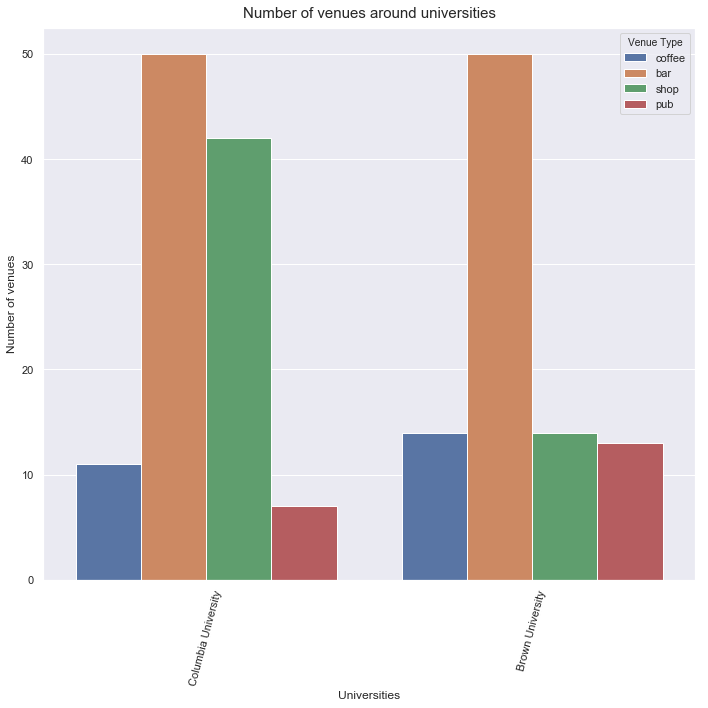

In [9]:
sns.set(style='darkgrid')

plt.figure(figsize=(10,10))
universities = data['University'].apply(lambda x: x.split(',')[0])
sns.countplot(universities, data = data, hue = 'Venue Type', order = universities.value_counts().index)
plt.xticks(rotation=75)
plt.title('Number of venues around universities', pad=10, fontsize = 15)
plt.ylabel('Number of venues')
plt.xlabel('Universities')
plt.tight_layout()

In [10]:
columbia = data[data['University'].apply(lambda x: 'Columbia' in x)]
brown = data[data['University'].apply(lambda x: 'Brown' in x)]
brown.head()

,address,categories,cc,city,country,crossStreet,distance,formattedAddress,id,labeledLatLngs,lat,lng,name,neighborhood,postalCode,Venue Type,state,University
0,244 Thayer St,Café,US,Providence,United States,NaN,150,"[244 Thayer St, Providence, RI 02912, United S...",562e7d9a498ec03db5f1d08a,"[{'label': 'display', 'lat': 41.828194, 'lng':...",41.828194,-71.400900,Blue State Coffee (Brown Bookstore),NaN,02912,coffee,RI,Brown University
1,300 Thayer St,Coffee Shop,US,Providence,United States,Cushing St.,359,"[300 Thayer St (Cushing St.), Providence, RI 0...",4b057f84f964a520d15822e3,"[{'label': 'display', 'lat': 41.830095, 'lng':...",41.830095,-71.401002,Blue State Coffee,NaN,02906,coffee,RI,Brown University
2,207 Wickenden St,Café,US,Providence,United States,NaN,851,"[207 Wickenden St, Providence, RI 02903, Unite...",4b0586aaf964a520816922e3,"[{'label': 'display', 'lat': 41.81939532626843...",41.819395,-71.399040,The Coffee Exchange,NaN,02903,coffee,RI,Brown University
3,224 Benefit St,Café,US,Providence,United States,Waterman Street,540,"[224 Benefit St (Waterman Street), Providence,...",576a89e9498eb721306bdbb4,"[{'label': 'display', 'lat': 41.82702321116954...",41.827023,-71.407741,Bolt Coffee at the RISD Museum,NaN,02903,coffee,RI,Brown University
4,341 S Main St,Coffee Shop,US,Providence,United States,NaN,658,"[341 S Main St, Providence, RI 02903, United S...",53bc1aee498e6b2c8c152021,"[{'label': 'display', 'lat': 41.82145541848680...",41.821455,-71.404446,Dave's Coffee,NaN,02903,coffee,RI,Brown University


In [117]:
general_location = geolocator.geocode('Northeastern United States')

venues_map = folium.Map(location=[general_location.latitude, general_location.longitude], zoom_start=5)

for university, location in locations.items():
    folium.features.CircleMarker(
        [location[0], location[1]],
        radius=10,
        color='red',
        popup=university,
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.6
    ).add_to(venues_map)
    
venues_map

In [11]:
def get_categories(categories):
    out = []
    for i in categories:
        out.append(i['name'])
    return ', '.join(i for i in out)

def get_open_days(timeframes):
    return len(timeframes)

def get_avg_hours_open(timeframes):
    h = 0
    pm = [24, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
    for i in timeframes:
        hours = i['open'][0]['renderedTime'].split('–')
        start = hours[0]
        end = hours[1]
        h += pm[int(end.split(':')[0])] - int(start.split(':')[0])
    return round(h / len(timeframes), 1)

def get_comments(tips):
    out = []
    for i in tips:
        out.append(i['text'])
    return ' '.join(i for i in out)
    
def get_rating(venue):
    try:
        out = venue['rating']
    except:
        out = 'No rating yet.'
    return out

def explore_venues(df):
    results = []

    for id in df['id']:
        try:
            url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(id, CLIENT_ID, CLIENT_SECRET, VERSION)
            venue = requests.get(url).json()['response']['venue']
            name = venue['name']
            city = venue['location']['city']
            state = venue['location']['state']
            categories = get_categories(venue['categories'])
            verified = 1 if venue['verified'] == 'True' else 0
            likes = venue['likes']['count']
            rating = get_rating(venue)
            photos = venue['photos']['count']
            tips = venue['tips']['count']
            open_days = get_open_days(venue['popular']['timeframes'])
            avg_hours_open = get_avg_hours_open(venue['popular']['timeframes'])
            comments = get_comments(venue['tips']['groups'][0]['items'])
            results.append([id, name, city, state, categories, verified, likes, rating, photos, tips, open_days, avg_hours_open, comments])
        except:
            continue
    return results

In [12]:
r = explore_venues(data)

In [13]:
clustering_df = pd.DataFrame.from_records(r, columns=['id', 'name', 'city', 'state', 'categories', 'verified',
                                                      'likes', 'rating', 'photos', 'tips', 'open_days',
                                                      'avg_hours_open', 'comments'])
clustering_df.head()

,id,name,city,state,categories,verified,likes,rating,photos,tips,open_days,avg_hours_open,comments
0,4b057f84f964a520d15822e3,Blue State Coffee,Providence,RI,Coffee Shop,0,112,8.0,43,27,7,10.0,Take a token from the counter and drop in the ...
1,4b0586aaf964a520816922e3,The Coffee Exchange,Providence,RI,"Café, Coffee Shop",0,162,8.5,83,70,6,11.5,This is what the energy of a coffee shop shoul...
2,53bc1aee498e6b2c8c152021,Dave's Coffee,Providence,RI,Coffee Shop,0,76,9.1,37,18,7,10.1,"Great atmosphere, great interior design and fe..."
3,4ad78fc2f964a5202d0c21e3,Starbucks,Providence,RI,Coffee Shop,0,73,7.2,33,16,6,10.0,"IF THE DRINK I CALLED IS NOT WHAT YOU ORDERED,..."
4,4a5e0d87f964a520f6bd1fe3,Starbucks,Providence,RI,Coffee Shop,0,63,7.5,64,21,6,11.0,try the wifi. get it unsweetened.


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clustering_df['comments'])
clustering_df['comments'] = pd.Series(list(X.toarray()))

In [54]:
data_to_cluster = pd.get_dummies(data[['id', 'categories', 'Venue Type']], columns=['categories', 'Venue Type'], prefix = '', prefix_sep='')
data_to_cluster = data_to_cluster.merge(clustering_df[['id', 'verified', 'likes', 'rating', 'photos', 'tips', 'open_days', 'avg_hours_open']],
                                          how='left', left_on='id', right_on='id').drop('id', axis = 1).fillna(method='pad').fillna(0)
data_to_cluster.head()

,American Restaurant,Art Gallery,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Betting Shop,Bike Shop,Bookstore,Boutique,Bubble Tea Shop,Building,Burger Joint,Business Service,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chiropractor,City,Coffee Shop,College Academic Building,College Administrative Building,College Gym,College Lab,College Quad,College Residence Hall,College Science Building,Cosmetics Shop,Cuban Restaurant,Deli / Bodega,Dentist's Office,Diner,Discount Store,Dive Bar,Flower Shop,Food,Food Truck,Furniture / Home Store,Gas Station,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym,Health & Beauty Service,Internet Cafe,Italian Restaurant,Juice Bar,Latin American Restaurant,Lawyer,Library,Lounge,Mediterranean Restaurant,Miscellaneous Shop,Music Venue,Nightclub,Non-Profit,Office,Pet Café,Pharmacy,Pizza Place,Playground,Professional & Other Places,Record Shop,Residential Building (Apartment / Condo),Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Repair,Smoke Shop,Spanish Restaurant,Sports Bar,Supermarket,Theater,University,Wine Bar,Wings Joint,bar,coffee,pub,shop,verified,likes,rating,photos,tips,open_days,avg_hours_open
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,112.0,8.0,43.0,27.0,7.0,10.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,162.0,8.5,83.0,70.0,6.0,11.5
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,162.0,8.5,83.0,70.0,6.0,11.5
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,76.0,9.1,37.0,18.0,7.0,10.1


In [55]:
kclusters = 2

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_to_cluster)

kmeans.labels_[0:10] 

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [56]:
data_to_cluster['Cluster Labels'] = kmeans.labels_

In [59]:
data_to_cluster[data_to_cluster['Cluster Labels'] == 1].head(2)

,American Restaurant,Art Gallery,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Betting Shop,Bike Shop,Bookstore,Boutique,Bubble Tea Shop,Building,Burger Joint,Business Service,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chiropractor,City,Coffee Shop,College Academic Building,College Administrative Building,College Gym,College Lab,College Quad,College Residence Hall,College Science Building,Cosmetics Shop,Cuban Restaurant,Deli / Bodega,Dentist's Office,Diner,Discount Store,Dive Bar,Flower Shop,Food,Food Truck,Furniture / Home Store,Gas Station,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym,Health & Beauty Service,Internet Cafe,Italian Restaurant,Juice Bar,Latin American Restaurant,Lawyer,Library,Lounge,Mediterranean Restaurant,Miscellaneous Shop,Music Venue,Nightclub,Non-Profit,Office,Pet Café,Pharmacy,Pizza Place,Playground,Professional & Other Places,Record Shop,Residential Building (Apartment / Condo),Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Repair,Smoke Shop,Spanish Restaurant,Sports Bar,Supermarket,Theater,University,Wine Bar,Wings Joint,bar,coffee,pub,shop,verified,likes,rating,photos,tips,open_days,avg_hours_open,Cluster Labels
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,162.0,8.5,83.0,70.0,6.0,11.5,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,162.0,8.5,83.0,70.0,6.0,11.5,1


In [60]:
data_to_cluster[data_to_cluster['Cluster Labels'] == 0].head(2)

,American Restaurant,Art Gallery,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Betting Shop,Bike Shop,Bookstore,Boutique,Bubble Tea Shop,Building,Burger Joint,Business Service,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chiropractor,City,Coffee Shop,College Academic Building,College Administrative Building,College Gym,College Lab,College Quad,College Residence Hall,College Science Building,Cosmetics Shop,Cuban Restaurant,Deli / Bodega,Dentist's Office,Diner,Discount Store,Dive Bar,Flower Shop,Food,Food Truck,Furniture / Home Store,Gas Station,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym,Health & Beauty Service,Internet Cafe,Italian Restaurant,Juice Bar,Latin American Restaurant,Lawyer,Library,Lounge,Mediterranean Restaurant,Miscellaneous Shop,Music Venue,Nightclub,Non-Profit,Office,Pet Café,Pharmacy,Pizza Place,Playground,Professional & Other Places,Record Shop,Residential Building (Apartment / Condo),Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Repair,Smoke Shop,Spanish Restaurant,Sports Bar,Supermarket,Theater,University,Wine Bar,Wings Joint,bar,coffee,pub,shop,verified,likes,rating,photos,tips,open_days,avg_hours_open,Cluster Labels
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,112.0,8.0,43.0,27.0,7.0,10.0,0
